# **ML-Based Portfolio Optimization**

Daksh Soni (dsoni9@uic.edu)

Rahul Gadhavi (rgadha2@uic.edu)

Aiswaryaa Velumani (avelu3@uic.edu)

**1. Introduction**

Our project looks at whether simple machine learning models can help with predicting short-term movements in the financial sector. We work with large U.S. financial stocks in the S&P 500 (for example JPMorgan Chase, Bank of America, Goldman Sachs and American Express), together with a broad market benchmark (SPY) and several macroeconomic indicators such as the VIX, the 10-year Treasury yield, the U.S. Dollar Index, crude oil and gold futures.


At this stage, we focus on a directional classification task: given yesterday’s information about stock returns and macro variables, can we predict whether a stock’s return tomorrow will be up (1) or down (0)? This is a first building block toward our bigger goal from the proposal, which is to use such predictions to construct and evaluate an ML-driven portfolio that can be compared to the S&P 500 benchmark.

**2. Changes since the proposal**

In the proposal we planned to:

*   predict next-day returns (regression) and/or direction,
*   use both traditional models (Logistic Regression, Random Forest XGBoost) and LSTM models for time-series prediction, and
*   feed these predictions into a portfolio allocation and backtesting framework.

So far, the main change is that we have narrowed the current progress report to directional prediction for a subset of financial stocks. Instead of directly predicting the exact next-day return, we first classify the sign of the next-day return (up/down). This is easier to evaluate and helps us debug the pipeline before moving to regression and portfolio construction.

The LSTM part is not implemented yet. We are still experimenting with feature engineering and the classical models, and we want a clean baseline and feature set before we move to sequence models. The plan is still to use an LSTM for next-day return prediction in the next phase and then plug those predictions into a portfolio strategy.

**3. Data: Collection and Preparation**

This part was done by - Daksh Soni

**Source**

Stock prices and the SPY benchmark are downloaded from Yahoo Finance using the yfinance library. Macroeconomic indicators are also taken from Yahoo Finance:

*   VIX Volatility Index (^VIX)
*   10Y U.S. Treasury yield (^TNX)
*   U.S. Dollar Index (DX-Y.NYB)
*   Crude oil futures (CL=F)
*   Gold futures (GC=F)

We download daily data from 2002-01-01 to 2025-01-01 and work with the Close prices for each series.

**Cleaning**

1.   After download, we first select the "Close" column for all tickers so that the dataset becomes a clean panel of closing prices indexed by date.
2.   There are some missing values because different assets have slightly different trading calendars and holidays.
To fix this, we forward-fill missing values within each column (ffill). This assumes that if a market is closed, the last available price is carried over to the next date.
3.   We then drop any remaining rows with NaNs that are introduced later when we create lagged features.

**Renaming and structure**

To make the columns easier to read, we map ticker symbols to descriptive names, for example:


*   JPM → JPMorgan Chase
*   ^VIX → VIX Volatility Index


We check df.info() and df.describe() to confirm:


*   all columns are numeric,
*   there is reasonable variation in prices across stocks and macro variables.
*   the time range is long enough, and

**Feature engineering**

We then create the features needed for the ML models:

*   Lagged prices (t–1) for each main stock and for SPY.
These approximate the information that would have been available at the close of the previous trading day.
*   Lagged macro indicators (t–1) for VIX, 10Y yield, dollar index, crude oil and gold.

After adding these lags, the earliest rows become NaN, so we drop them.

Next, for the four target stocks (JPMorgan Chase, Bank of America, Goldman Sachs, American Express) we create:



*   Daily returns: \(Pt​−Pt−1​)/Pt−1​
*   Lagged returns (t–1): the previous day’s return.

Finally, we define labels:

*   For each stock, we compute the next-day return by shifting the return series by one day.
*   The binary target is 1 if the next-day return is positive, and 0 otherwise.

**Train/test split**

Because this is time-series data, we do not shuffle.
We use the first 80% of the timeline as the training set and the most recent 20% as the test set, which is closer to how the model would be used in practice.

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
# Tickers for large financial stocks in the S&P 500
# (main focus of the project)
financial_tickers = [
    "JPM",   # JPMorgan Chase
    "BAC",   # Bank of America
    "WFC",   # Wells Fargo
    "C",     # Citigroup
    "GS",    # Goldman Sachs
    "MS",    # Morgan Stanley
    "AXP",   # American Express
    "SCHW",  # Charles Schwab
    "BLK",   # BlackRock
    "MCO",   # Moody's
    "SPGI",  # S&P Global
    "BRK-B"  # Berkshire Hathaway Class B
]

# Benchmark index: S&P 500 ETF
index_ticker = ["SPY"]

# Macroeconomic indicators
macro_tickers = [
    "^VIX",     # CBOE Volatility Index (market uncertainty)
    "^TNX",     # 10Y US Treasury Yield (interest rate level)
    "DX-Y.NYB", # US Dollar Index
    "CL=F",     # Crude Oil futures (energy / inflation proxy)
    "GC=F"      # Gold futures (safe haven asset)
]

tickers = financial_tickers + index_ticker + macro_tickers

In [ ]:
# Download daily price data from Yahoo Finance
df = yf.download(tickers, start="2002-01-01", end="2025-01-01")

# Keep only closing prices
df = df["Close"]

# Quick check for missing values before cleaning
df.isnull().sum()

/tmp/ipython-input-965116467.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start="2002-01-01", end="2025-01-01")
[*********************100%***********************]  18 of 18 completed


,0
Ticker,
AXP,21
BAC,21
BLK,21
BRK-B,21
C,21
CL=F,31
DX-Y.NYB,3
GC=F,35
GS,21


In [ ]:
# Forward-fill missing values (e.g., holidays / different trading calendars)
df = df.ffill()

# Confirm that remaining missing values are minimal / gone
df.isnull().sum()

,0
Ticker,
AXP,0
BAC,0
BLK,0
BRK-B,0
C,0
CL=F,0
DX-Y.NYB,0
GC=F,0
GS,0


In [ ]:
name_map = {
    "JPM": "JPMorgan Chase",
    "BAC": "Bank of America",
    "WFC": "Wells Fargo",
    "C": "Citigroup",
    "GS": "Goldman Sachs",
    "MS": "Morgan Stanley",
    "AXP": "American Express",
    "SCHW": "Charles Schwab",
    "BLK": "BlackRock",
    "MCO": "Moody's",
    "SPGI": "S&P Global",
    "BRK-B": "Berkshire Hathaway",
    "SPY": "S&P500 ETF",
    "^VIX": "VIX Volatility Index",
    "^TNX": "10Y Treasury Yield",
    "DX-Y.NYB": "US Dollar Index",
    "CL=F": "Crude Oil Futures",
    "GC=F": "Gold Futures"
}

df = df.rename(columns=name_map)

# Basic info about the dataset after renaming
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5810 entries, 2002-01-02 to 2024-12-31
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   American Express      5810 non-null   float64
 1   Bank of America       5810 non-null   float64
 2   BlackRock             5810 non-null   float64
 3   Berkshire Hathaway    5810 non-null   float64
 4   Citigroup             5810 non-null   float64
 5   Crude Oil Futures     5810 non-null   float64
 6   US Dollar Index       5810 non-null   float64
 7   Gold Futures          5810 non-null   float64
 8   Goldman Sachs         5810 non-null   float64
 9   JPMorgan Chase        5810 non-null   float64
 10  Moody's               5810 non-null   float64
 11  Morgan Stanley        5810 non-null   float64
 12  Charles Schwab        5810 non-null   float64
 13  S&P Global            5810 non-null   float64
 14  S&P500 ETF            5810 non-null   float64
 15  Wel

In [ ]:
# Summary statistics for all price series
df.describe()

Ticker,American Express,Bank of America,BlackRock,Berkshire Hathaway,Citigroup,Crude Oil Futures,US Dollar Index,Gold Futures,Goldman Sachs,JPMorgan Chase,Moody's,Morgan Stanley,Charles Schwab,S&P Global,S&P500 ETF,Wells Fargo,10Y Treasury Yield,VIX Volatility Index
count,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000,5810.000000
mean,74.019781,21.858000,280.108515,147.082289,109.292528,66.668348,90.836115,1207.809931,164.277554,59.991540,118.430269,37.006334,28.330292,132.442968,188.325403,29.184455,3.084188,19.461525
std,55.151715,9.920154,243.529481,102.695196,109.460300,24.106086,10.090941,556.690234,100.538000,48.912907,121.173822,23.493336,21.157532,140.694360,132.898084,12.867546,1.159698,8.606134
min,7.952188,2.442875,20.626575,40.000000,7.568429,-37.630001,71.330002,278.100006,38.961983,8.126895,12.757780,6.377223,4.812899,13.073554,50.092171,5.326457,0.499000,9.140000
25%,34.764567,12.611349,96.554352,66.220001,36.242605,48.392500,81.879997,709.774979,94.125368,24.720872,28.533744,21.316559,11.765855,30.028366,86.207163,17.965070,2.133250,13.602500
50%,53.789906,22.648319,197.681572,112.080002,50.249918,66.075001,90.779999,1251.549988,135.069092,37.302212,57.096682,28.923245,18.854403,50.212198,132.537231,23.968745,2.987500,17.095000
75%,93.407934,29.211292,407.207512,203.010002,197.451534,84.275002,97.827501,1645.924988,191.228970,89.008850,171.396294,41.924691,40.183700,199.569851,255.740536,40.519741,4.108750,22.520000
max,302.313324,46.671665,1048.942993,483.079987,378.467682,145.289993,120.239998,2788.500000,596.400696,245.101456,498.076111,131.313080,90.695747,525.229797,600.509277,75.704926,5.428000,82.690002


In [ ]:
# Lagged price features for individual financial stocks
df["American Express(t-1)"]      = df["American Express"].shift(1)
df["Bank of America(t-1)"]       = df["Bank of America"].shift(1)
df["BlackRock(t-1)"]             = df["BlackRock"].shift(1)
df["Berkshire Hathaway(t-1)"]    = df["Berkshire Hathaway"].shift(1)
df["Citigroup(t-1)"]             = df["Citigroup"].shift(1)
df["Goldman Sachs(t-1)"]         = df["Goldman Sachs"].shift(1)
df["JPMorgan Chase(t-1)"]        = df["JPMorgan Chase"].shift(1)
df["Moody's(t-1)"]               = df["Moody's"].shift(1)
df["Morgan Stanley(t-1)"]        = df["Morgan Stanley"].shift(1)
df["Charles Schwab(t-1)"]        = df["Charles Schwab"].shift(1)
df["S&P Global(t-1)"]            = df["S&P Global"].shift(1)
df["Wells Fargo(t-1)"]           = df["Wells Fargo"].shift(1)
df["S&P500 ETF(t-1)"]            = df["S&P500 ETF"].shift(1)

# Lagged macroeconomic features
df["VIX Volatility Index(t-1)"]  = df["VIX Volatility Index"].shift(1)
df["10Y Treasury Yield(t-1)"]    = df["10Y Treasury Yield"].shift(1)
df["Gold Futures(t-1)"]          = df["Gold Futures"].shift(1)
df["US Dollar Index(t-1)"]       = df["US Dollar Index"].shift(1)
df["Crude Oil Futures(t-1)"]     = df["Crude Oil Futures"].shift(1)

In [ ]:
# Drop rows with NaNs created by shifting (at the start of the series)
df = df.dropna()

# Final check: should be no missing values now
df.isnull().sum()

,0
Ticker,
American Express,0
Bank of America,0
BlackRock,0
Berkshire Hathaway,0
Citigroup,0
Crude Oil Futures,0
US Dollar Index,0
Gold Futures,0
Goldman Sachs,0


In [ ]:
# Keep only lagged macro indicators in the feature set
macro_today = [
    "VIX Volatility Index",
    "10Y Treasury Yield",
    "Gold Futures",
    "US Dollar Index",
    "Crude Oil Futures"
]

df = df.drop(columns=macro_today)

**4. EDA**

This part was done by - Rahul Gadhavi

The dataset contains daily closing prices for major U.S. financial institutions, the S&P 500 benchmark, and key macroeconomic indicators (VIX, Treasury yields, the dollar index, oil, and gold). After cleaning and aligning the time series, we generated returns, lagged features, and several diagnostic plots to understand overall structure, relationships, and potential predictive signals. The following visualizations summarize the key patterns, dependencies, and preliminary insights uncovered in the data.

**4.1. Price Trends**

This visualization shows long-term price evolution across 12 financial institutions. The stocks move together through major events such as the 2008 financial crisis and the COVID-19 crash, highlighting strong sector co-movement and macro sensitivity.

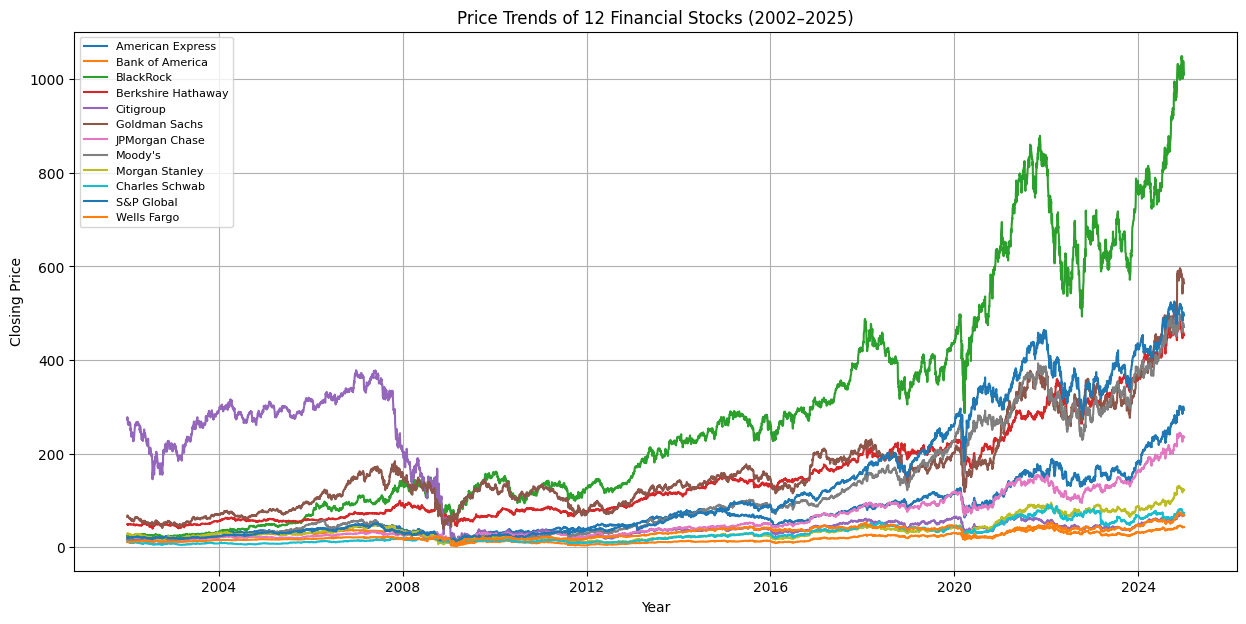

In [ ]:
# List of 12 financial stocks
financial_stocks = [
    "American Express", "Bank of America", "BlackRock", "Berkshire Hathaway",
    "Citigroup", "Goldman Sachs", "JPMorgan Chase", "Moody's",
    "Morgan Stanley", "Charles Schwab", "S&P Global", "Wells Fargo"
]

# Macro indicators (lagged versions only)
macro_cols = [
    "VIX Volatility Index(t-1)", "10Y Treasury Yield(t-1)",
    "Gold Futures(t-1)", "US Dollar Index(t-1)", "Crude Oil Futures(t-1)"
]

# Benchmark ETF
benchmark = ["S&P500 ETF"]


# 1. PRICE TRENDS FOR 12 STOCKS

plt.figure(figsize=(15,7))
for stock in financial_stocks:
    plt.plot(df[stock], label=stock)

plt.title("Price Trends of 12 Financial Stocks (2002–2025)")
plt.xlabel("Year")
plt.ylabel("Closing Price")
plt.legend(loc='upper left', fontsize=8)
plt.grid(True)
plt.show()




**4.2. Correlation Heatmap**

Financial stocks exhibit high positive correlations, confirming shared risk exposures. Macro indicators display independent correlation patterns, supporting their role as useful predictive features.

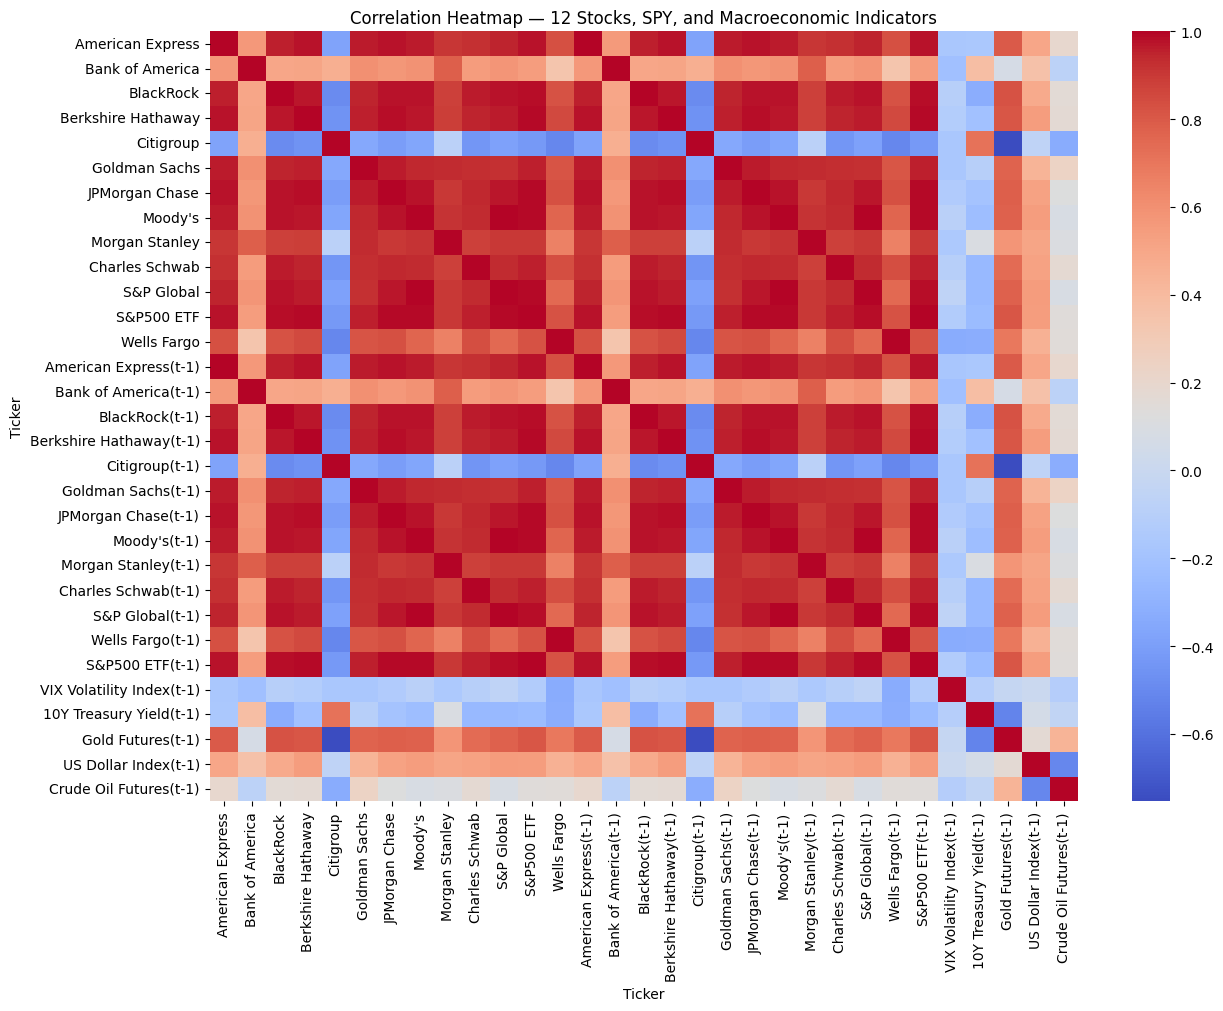

In [ ]:
# 2. CORRELATION HEATMAP

plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap — 12 Stocks, SPY, and Macroeconomic Indicators")
plt.show()


**4.3. KDE Return Distributions**

All stocks show heavy-tailed return distributions, meaning extreme movements occur more frequently than under a normal distribution. This highlights the need for non-linear ML models capable of handling volatility and tail risk.

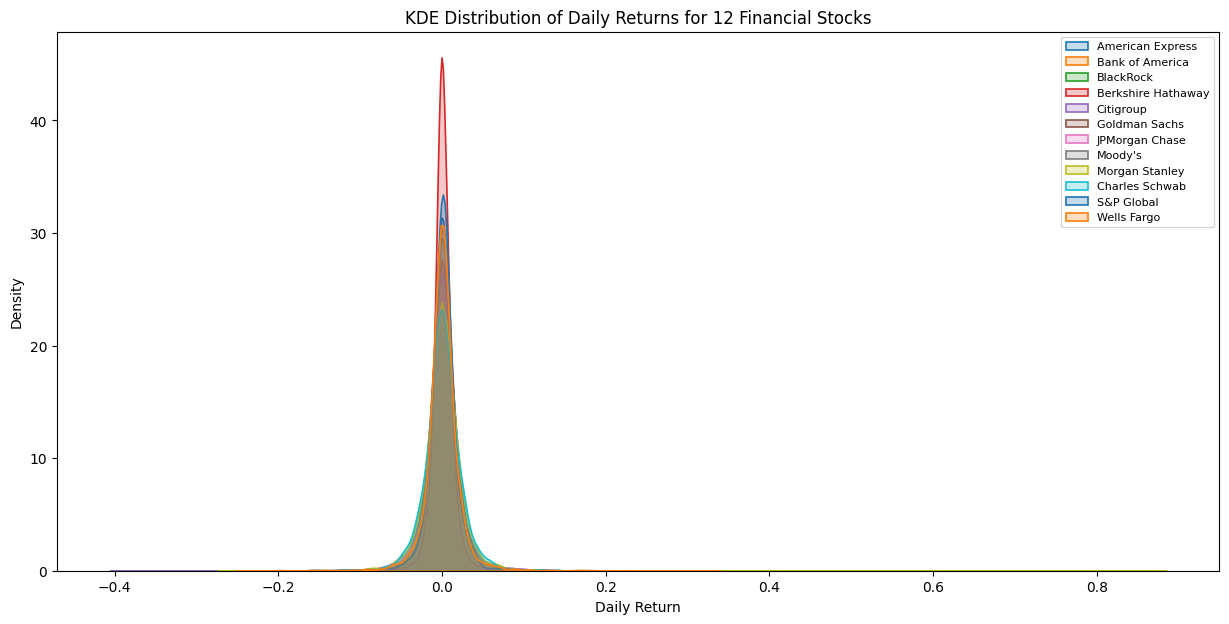

In [ ]:
df_returns = df[financial_stocks].pct_change()

plt.figure(figsize=(15,7))
for stock in financial_stocks:
    sns.kdeplot(df_returns[stock].dropna(), fill=True, label=stock, linewidth=1.2)

plt.title("KDE Distribution of Daily Returns for 12 Financial Stocks")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.legend(fontsize=8)
plt.show()


**4.4. Pairplot**

The pairplot reveals strong linear relationships among most stock returns, indicating shared market drivers and validating cross-stock feature engineering.

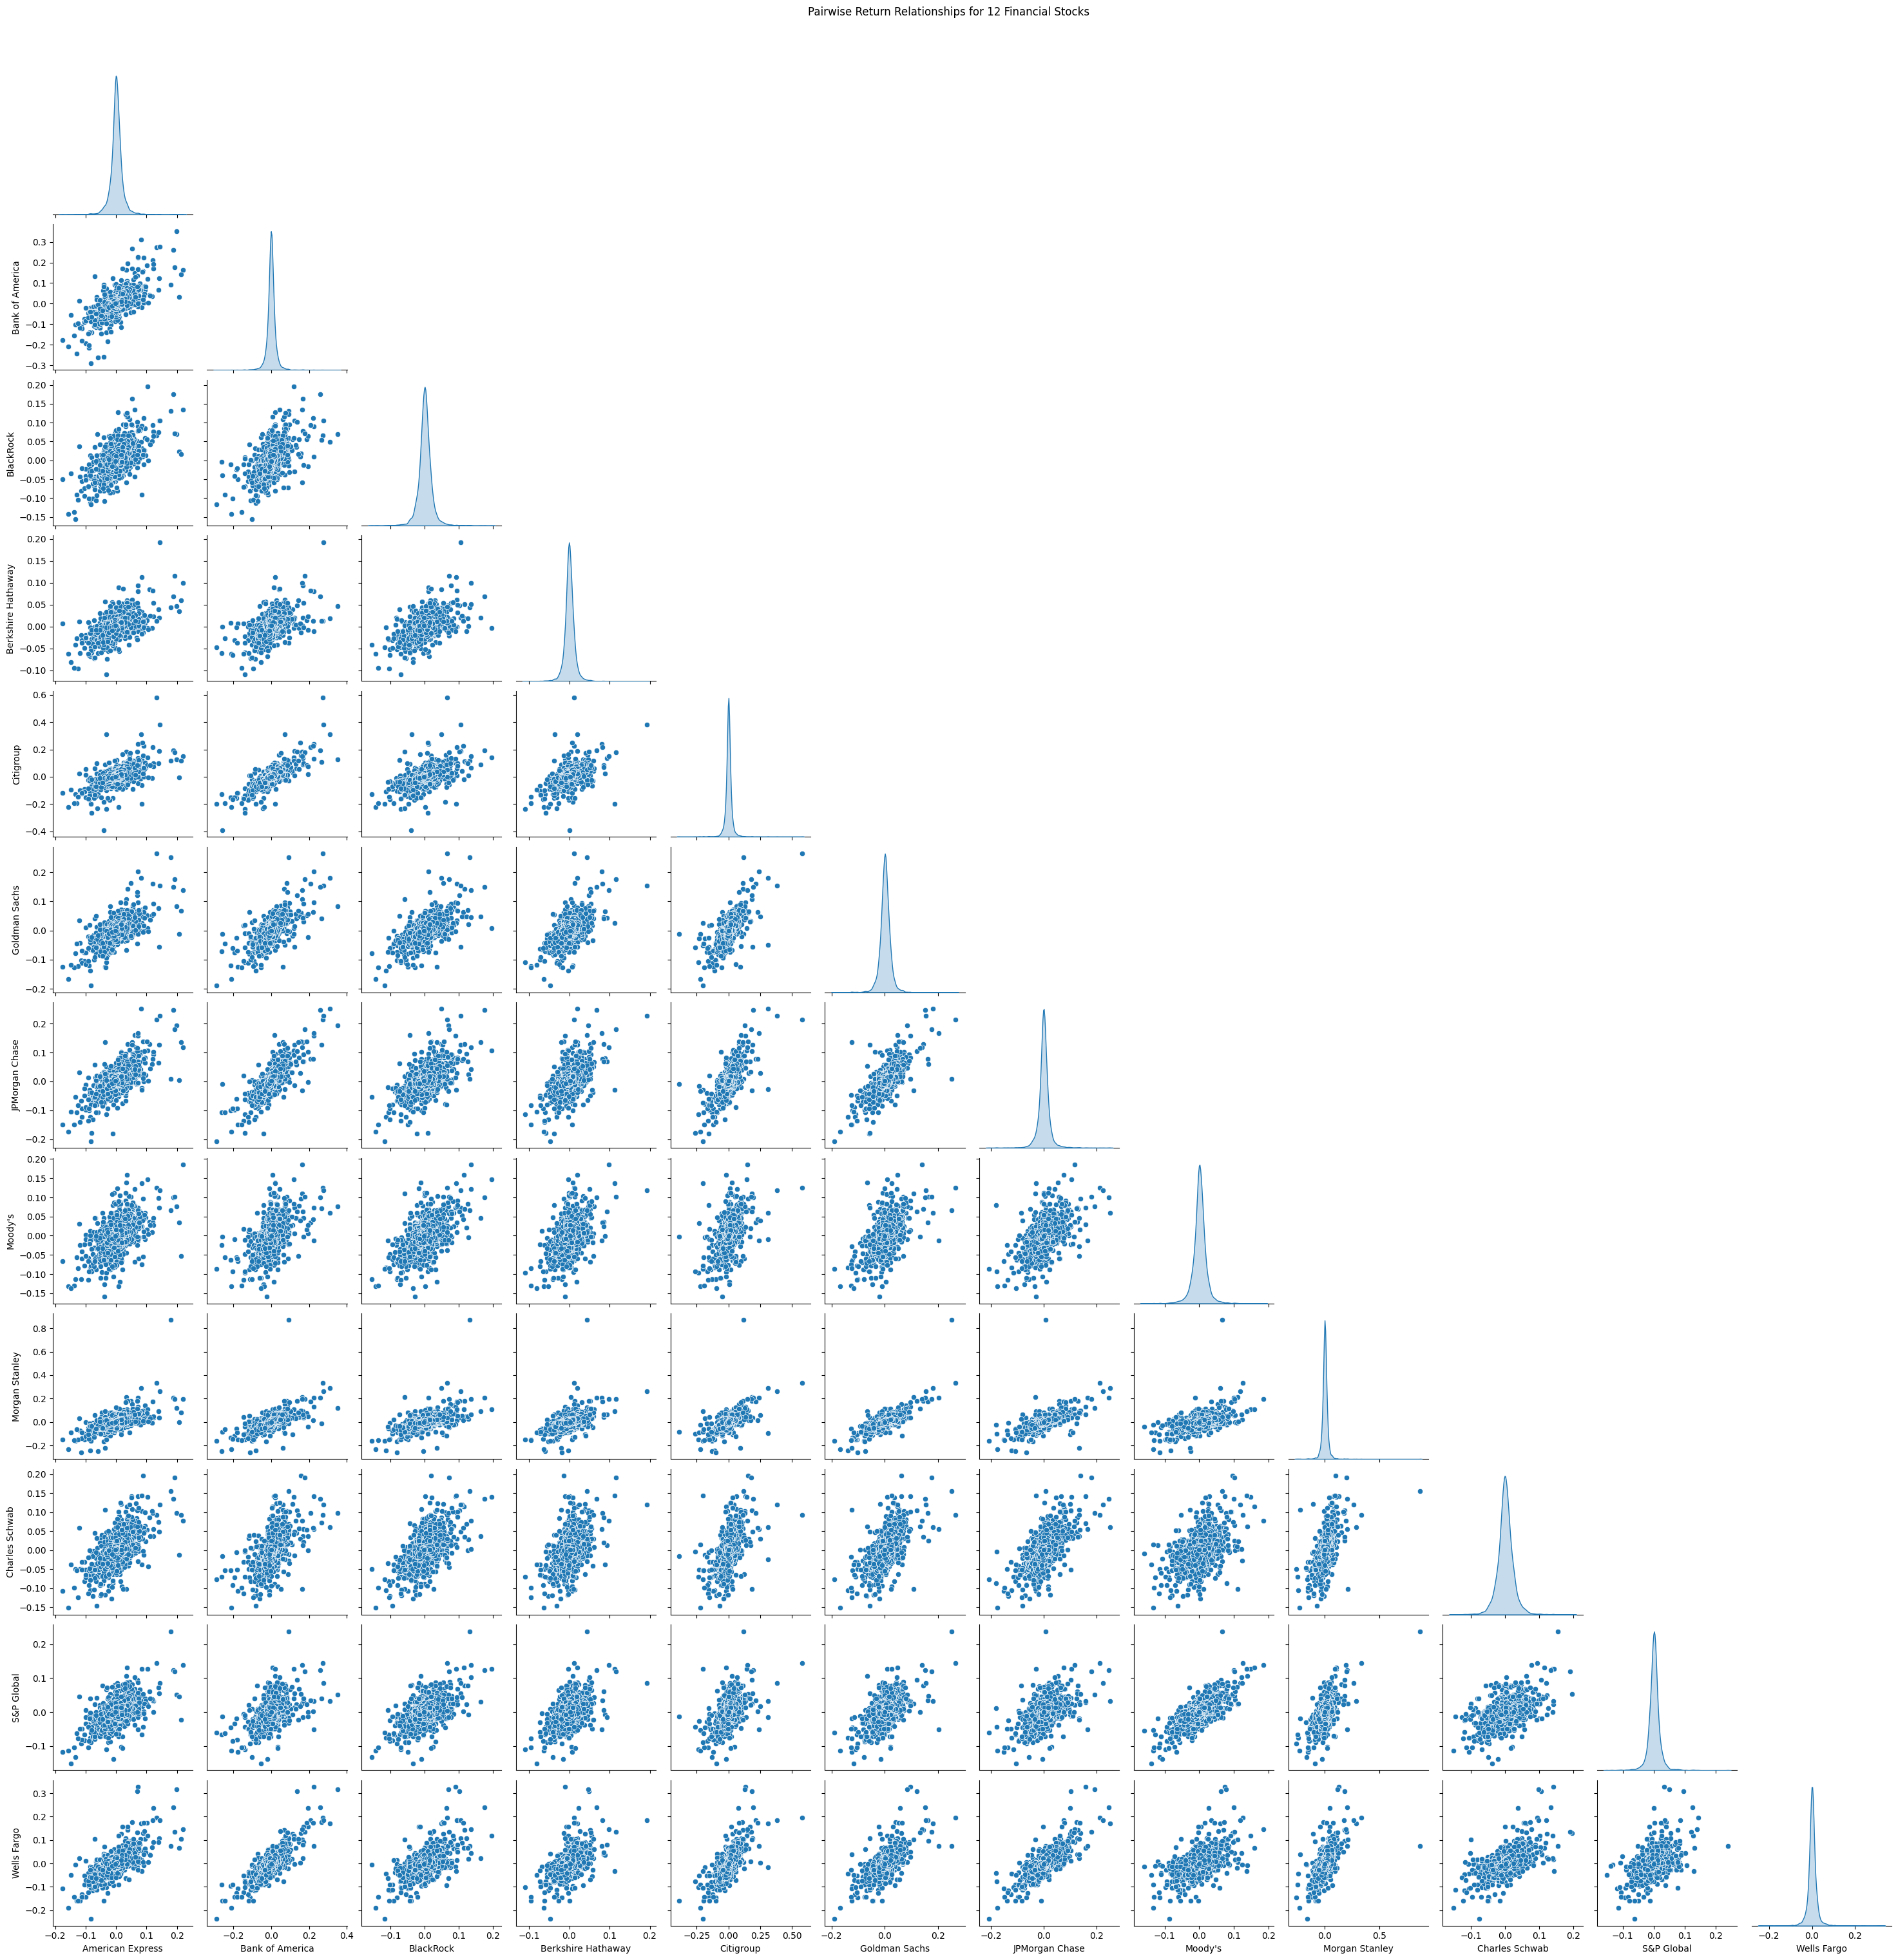

In [ ]:
# 4. PAIRPLOT OF RETURNS

sns.pairplot(df_returns[financial_stocks].dropna(), diag_kind="kde", corner=True)
plt.suptitle("Pairwise Return Relationships for 12 Financial Stocks", y=1.02)
plt.show()

**4.5. Rolling Volatility**

Volatility clustering is clearly visible. Sudden spikes correspond to market stress events. ML models must adapt to these volatility regimes, justifying the use of rolling volatility features.

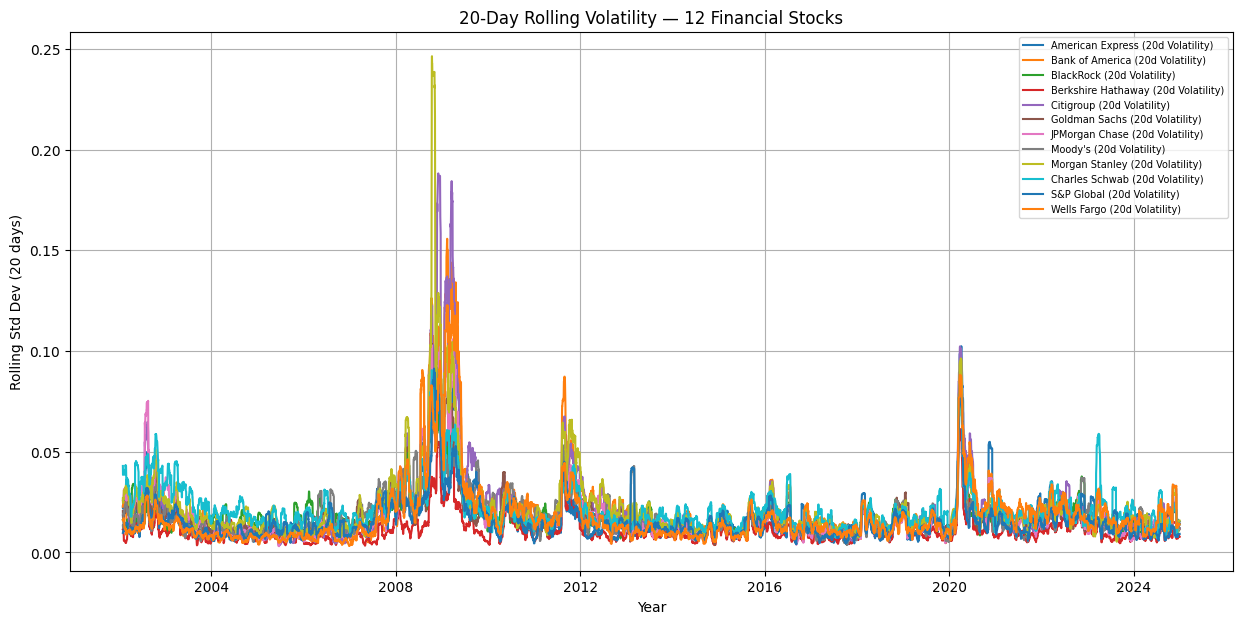

In [ ]:
# 5. 20-DAY ROLLING VOLATILITY

plt.figure(figsize=(15,7))
for stock in financial_stocks:
    plt.plot(
        df_returns[stock].rolling(20).std(),
        label=f"{stock} (20d Volatility)"
    )

plt.title("20-Day Rolling Volatility — 12 Financial Stocks")
plt.xlabel("Year")
plt.ylabel("Rolling Std Dev (20 days)")
plt.legend(fontsize=7)
plt.grid(True)
plt.show()

**4.6. Autocorrelation Bar Plot**

Most stocks exhibit slightly negative lag-1 autocorrelation, implying mean reversion in daily returns. This demonstrates the limited predictive power of past returns alone.

/tmp/ipython-input-2236676745.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


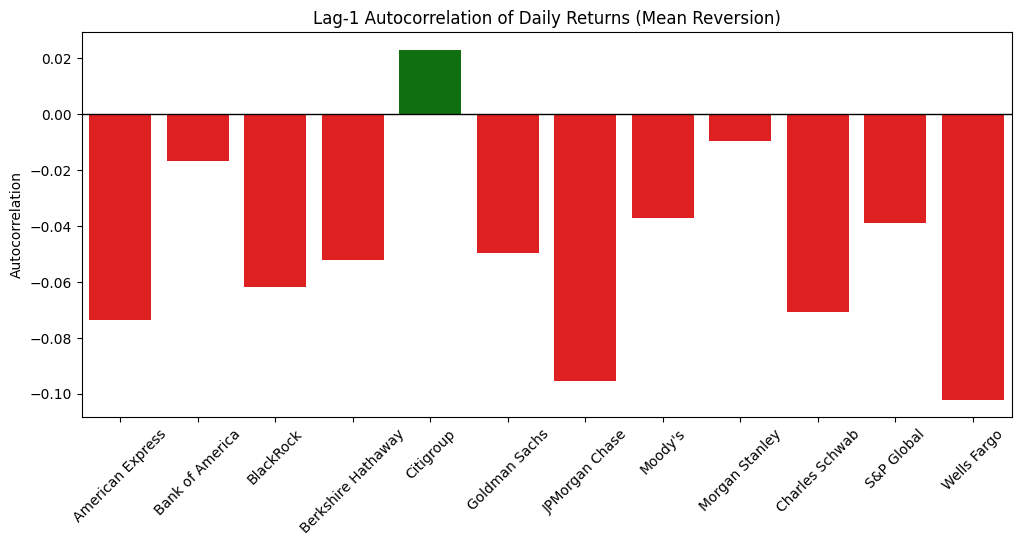

In [ ]:
# 6. LAG-1 AUTOCORRELATION
autocorr_values = {}

for stock in financial_stocks:
    autocorr_values[stock] = df_returns[stock].autocorr(lag=1)

plt.figure(figsize=(12,5))
sns.barplot(
    x=list(autocorr_values.keys()),
    y=list(autocorr_values.values()),
    palette=["red" if v < 0 else "green" for v in autocorr_values.values()]
)

plt.axhline(0, color='black', linewidth=1)
plt.title("Lag-1 Autocorrelation of Daily Returns (Mean Reversion)")
plt.ylabel("Autocorrelation")
plt.xticks(rotation=45)
plt.show()

**5. ML analyses**

Implementation for this part was done by:



*   Baseline and Logistic Regression: Daksh Soni
*   Feature Selection, Random Forest, XGBoost, and comparison: Aiswaryaa Velumani


**5.1. Feature Selection and Return Construction**

Before building the baseline and ML models, we needed to prepare a structured dataset that contains only the relevant features for prediction. The steps below describe how we narrowed down the data, engineered returns, created labels, and built a proper time-based train/test split.




**5.1.1.   Selecting the Target Stocks:** From the larger financial-sector dataset, I decided to focus on the following four major stocks:


*   JPMorgan Chase
*  Bank of America
*   Goldman Sachs
*   American Express



**5.1.2.   Selecting Relevant Predictors:** For each of the four target stocks, I kept:


*   **Current stock prices:** These serve as the base series from which returns are calculated.
*   **Lagged prices (t–1):** Lag features capture information available at the previous day’s close, which is essential because our goal is to predict the next day’s movement without introducing data leakage.
*   **Lagged macroeconomic indicators (t–1):** We also identified and retained lagged versions of the following macro series.

By filtering down to these features, a new dataset df_filtered is created containing only stock prices, their lagged values, and the macro lags.

In [ ]:
# Choose 4 main target stocks for direction prediction
target_stocks = [
    "JPMorgan Chase",
    "Bank of America",
    "Goldman Sachs",
    "American Express"
]

print("Target stocks:", target_stocks)

# Base names of macro indicators (only lagged versions are in df now)
macro_base_names = [
    "VIX Volatility Index",
    "10Y Treasury Yield",
    "Gold Futures",
    "US Dollar Index",
    "Crude Oil Futures"
]

# Lagged price columns for the 4 stocks
stock_lag_features = [f"{stock}(t-1)" for stock in target_stocks]

# Lagged macro columns
macro_lag_cols = [
    col for col in df.columns
    if any(base in col for base in macro_base_names) and "(t-1)" in col
]

# Final columns to keep for modeling
cols_to_keep = target_stocks + stock_lag_features + macro_lag_cols
cols_to_keep = [c for c in cols_to_keep if c in df.columns]

df_filtered = df[cols_to_keep].copy()

print("Shape of df_filtered:", df_filtered.shape)
print("Columns in df_filtered:", df_filtered.columns.tolist())
df_filtered.head()

Target stocks: ['JPMorgan Chase', 'Bank of America', 'Goldman Sachs', 'American Express']
Shape of df_filtered: (5809, 13)
Columns in df_filtered: ['JPMorgan Chase', 'Bank of America', 'Goldman Sachs', 'American Express', 'JPMorgan Chase(t-1)', 'Bank of America(t-1)', 'Goldman Sachs(t-1)', 'American Express(t-1)', 'VIX Volatility Index(t-1)', '10Y Treasury Yield(t-1)', 'Gold Futures(t-1)', 'US Dollar Index(t-1)', 'Crude Oil Futures(t-1)']


Ticker,JPMorgan Chase,Bank of America,Goldman Sachs,American Express,JPMorgan Chase(t-1),Bank of America(t-1),Goldman Sachs(t-1),American Express(t-1),VIX Volatility Index(t-1),10Y Treasury Yield(t-1),Gold Futures(t-1),US Dollar Index(t-1),Crude Oil Futures(t-1)
Date,,,,,,,,,,,,,
2002-01-03,18.899752,17.621578,65.221031,22.856506,18.408520,17.641195,64.247459,22.499073,22.709999,5.157,278.899994,115.790001,21.010000
2002-01-04,19.750540,17.896166,68.254532,23.652872,18.899752,17.621578,65.221031,22.856506,21.340000,5.120,278.200012,116.110001,20.370001
2002-01-07,19.699898,17.683218,67.549088,23.577623,19.750540,17.896166,68.254532,23.652872,20.450001,5.141,278.899994,116.330002,21.620001
2002-01-08,19.547966,17.400227,65.256294,23.232738,19.699898,17.683218,67.549088,23.577623,21.940001,5.057,278.600006,116.330002,21.480000
2002-01-09,19.603674,17.358189,66.138123,23.295443,19.547966,17.400227,65.256294,23.232738,21.830000,5.057,278.899994,116.830002,21.250000


**5.1.3. Computing Daily Returns and Lagged Returns:** Stock returns carry more meaningful information for prediction than raw prices. So for each target stock, we computed:


*   **Daily Return**
*   **Lagged Return (t–1)**


A new dataset df_returns is formed that includes:

*   current returns
*   lagged returns
*   stock prices and lag features
*   macro lag features


This dataset is then used to build the supervised learning labels.

In [ ]:
# Start from filtered price + lag data
df_returns = df_filtered.copy()

# Daily returns: (P_t - P_{t-1}) / P_{t-1}
for stock in target_stocks:
    df_returns[f"{stock}_ret"] = df_returns[stock].pct_change()

# Lagged returns: previous day return
for stock in target_stocks:
    df_returns[f"{stock}_ret(t-1)"] = df_returns[f"{stock}_ret"].shift(1)

df_returns.head()

Ticker,JPMorgan Chase,Bank of America,Goldman Sachs,American Express,JPMorgan Chase(t-1),Bank of America(t-1),Goldman Sachs(t-1),American Express(t-1),VIX Volatility Index(t-1),10Y Treasury Yield(t-1),...,US Dollar Index(t-1),Crude Oil Futures(t-1),JPMorgan Chase_ret,Bank of America_ret,Goldman Sachs_ret,American Express_ret,JPMorgan Chase_ret(t-1),Bank of America_ret(t-1),Goldman Sachs_ret(t-1),American Express_ret(t-1)
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-03,18.899752,17.621578,65.221031,22.856506,18.408520,17.641195,64.247459,22.499073,22.709999,5.157,...,115.790001,21.010000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-04,19.750540,17.896166,68.254532,23.652872,18.899752,17.621578,65.221031,22.856506,21.340000,5.120,...,116.110001,20.370001,0.045016,0.015582,0.046511,0.034842,NaN,NaN,NaN,NaN
2002-01-07,19.699898,17.683218,67.549088,23.577623,19.750540,17.896166,68.254532,23.652872,20.450001,5.141,...,116.330002,21.620001,-0.002564,-0.011899,-0.010335,-0.003181,0.045016,0.015582,0.046511,0.034842
2002-01-08,19.547966,17.400227,65.256294,23.232738,19.699898,17.683218,67.549088,23.577623,21.940001,5.057,...,116.330002,21.480000,-0.007712,-0.016003,-0.033943,-0.014628,-0.002564,-0.011899,-0.010335,-0.003181
2002-01-09,19.603674,17.358189,66.138123,23.295443,19.547966,17.400227,65.256294,23.232738,21.830000,5.057,...,116.830002,21.250000,0.002850,-0.002416,0.013513,0.002699,-0.007712,-0.016003,-0.033943,-0.014628


**5.1.4. Creating Next-Day Return and Direction Labels**

To frame this as a binary classification problem, we generate:


*   Next-Day Return (t+1)
*   Binary Target Variable

In [ ]:
# Create ML dataset with next-day returns and binary direction labels
df_ml = df_returns.copy()

label_cols = []
return_cols = []

for stock in target_stocks:
    # Next-day return based on today's return series
    ret_col = f"{stock}_return_t+1"
    df_ml[ret_col] = df_ml[f"{stock}_ret"].shift(-1)
    return_cols.append(ret_col)

    # Binary target: 1 if next-day return > 0, else 0
    label_col = f"{stock}_target"
    df_ml[label_col] = (df_ml[ret_col] > 0).astype(int)
    label_cols.append(label_col)

# Drop rows with missing values created by shifting
df_ml = df_ml.dropna().copy()

print("df_ml shape:", df_ml.shape)
print("Label columns:", label_cols)
df_ml.head()

df_ml shape: (5806, 29)
Label columns: ['JPMorgan Chase_target', 'Bank of America_target', 'Goldman Sachs_target', 'American Express_target']


Ticker,JPMorgan Chase,Bank of America,Goldman Sachs,American Express,JPMorgan Chase(t-1),Bank of America(t-1),Goldman Sachs(t-1),American Express(t-1),VIX Volatility Index(t-1),10Y Treasury Yield(t-1),...,Goldman Sachs_ret(t-1),American Express_ret(t-1),JPMorgan Chase_return_t+1,JPMorgan Chase_target,Bank of America_return_t+1,Bank of America_target,Goldman Sachs_return_t+1,Goldman Sachs_target,American Express_return_t+1,American Express_target
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-07,19.699898,17.683218,67.549088,23.577623,19.750540,17.896166,68.254532,23.652872,20.450001,5.141,...,0.046511,0.034842,-0.007712,0,-0.016003,0,-0.033943,0,-0.014628,0
2002-01-08,19.547966,17.400227,65.256294,23.232738,19.699898,17.683218,67.549088,23.577623,21.940001,5.057,...,-0.010335,-0.003181,0.002850,1,-0.002416,0,0.013513,1,0.002699,1
2002-01-09,19.603674,17.358189,66.138123,23.295443,19.547966,17.400227,65.256294,23.232738,21.830000,5.057,...,-0.033943,-0.014628,0.011108,1,0.000807,1,-0.008000,0,0.016689,1
2002-01-10,19.821426,17.372198,65.609009,23.684223,19.603674,17.358189,66.138123,23.295443,22.129999,5.062,...,0.013513,0.002699,-0.020438,0,-0.017741,0,-0.019892,0,-0.009267,0
2002-01-11,19.416307,17.063995,64.303894,23.464752,19.821426,17.372198,65.609009,23.684223,22.360001,4.962,...,-0.008000,0.016689,-0.026865,0,-0.002956,0,-0.012946,0,-0.031267,0


**5.1.5. Constructing the Final Feature Set:** The final feature set includes:


*   Daily returns for each stock
*   Lagged daily returns
*   Lagged macro indicators

These collectively capture short-term market behavior and macroeconomic context. Only existing and validated columns are included in feature_cols.

In [ ]:
# Return-based features
ret_cols = [f"{stock}_ret" for stock in target_stocks]
ret_lag_cols = [f"{stock}_ret(t-1)" for stock in target_stocks]

# Macro lag features
macro_lag_cols = [
    col for col in df_ml.columns
    if any(base in col for base in macro_base_names) and "(t-1)" in col
]

# Final feature list (only keep columns that actually exist)
feature_cols = [c for c in (ret_cols + ret_lag_cols + macro_lag_cols) if c in df_ml.columns]

print("Number of feature columns:", len(feature_cols))
print("Feature columns:", feature_cols)

# Feature matrix
X = df_ml[feature_cols].values

# Time-based 80/20 split (no shuffling – respects temporal order)
n_samples = len(df_ml)
train_size = int(n_samples * 0.8)

X_train = X[:train_size]
X_test  = X[train_size:]

print("Total samples:", n_samples)
print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

Number of feature columns: 13
Feature columns: ['JPMorgan Chase_ret', 'Bank of America_ret', 'Goldman Sachs_ret', 'American Express_ret', 'JPMorgan Chase_ret(t-1)', 'Bank of America_ret(t-1)', 'Goldman Sachs_ret(t-1)', 'American Express_ret(t-1)', 'VIX Volatility Index(t-1)', '10Y Treasury Yield(t-1)', 'Gold Futures(t-1)', 'US Dollar Index(t-1)', 'Crude Oil Futures(t-1)']
Total samples: 5806
Train samples: 4644
Test samples: 1162


**6. EDA for ML features**

This part was done by - Rahul Gadhavi

- Price Trend of Major Financial Stocks

This plot presents the long-term price movements of four major U.S. financial stocks from 2002 to 2025. The stocks exhibit clear co-movement across major market cycles, including sharp declines during the 2008 financial crisis and the COVID-19 crash. These shared movements highlight how strongly financial institutions respond to macroeconomic and systemic shocks. Understanding these structural patterns is important because machine learning models must operate on data that is influenced by long-term regimes, market cycles, and volatility clusters. This visualization sets the foundation for why short-term prediction is challenging—prices do not move independently but are heavily driven by sector-wide and market-wide forces.

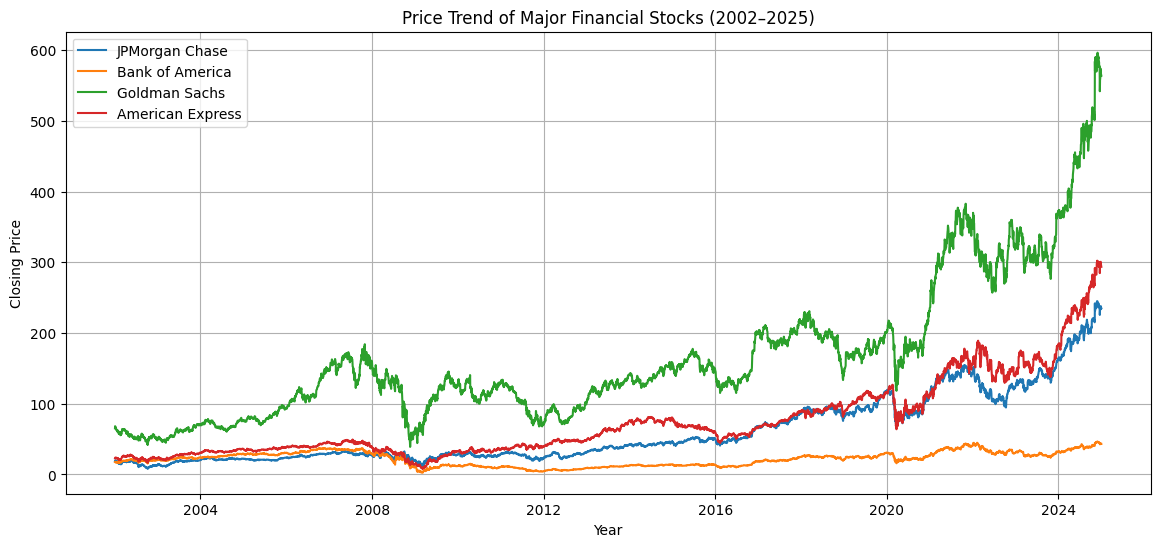

In [ ]:
plt.figure(figsize=(14,6))
for stock in ["JPMorgan Chase", "Bank of America", "Goldman Sachs", "American Express"]:
    plt.plot(df[stock], label=stock)

plt.title("Price Trend of Major Financial Stocks (2002–2025)")
plt.xlabel("Year")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.show()

- KDE Distribution of Daily Returns

In this below KDE plot we illustrate the probability distributions of daily returns for the four selected financial stocks. All distributions exhibit heavy tails, indicating that extreme price movements occur more frequently than would be expected under a normal distribution. This heavy-tailed behavior is typical of financial markets and emphasizes the need for models that can capture non-linearities and sudden volatility spikes. The shape of these distributions also highlights why simple linear models often struggle—markets are far more erratic and noisy than classical statistical assumptions suggest.

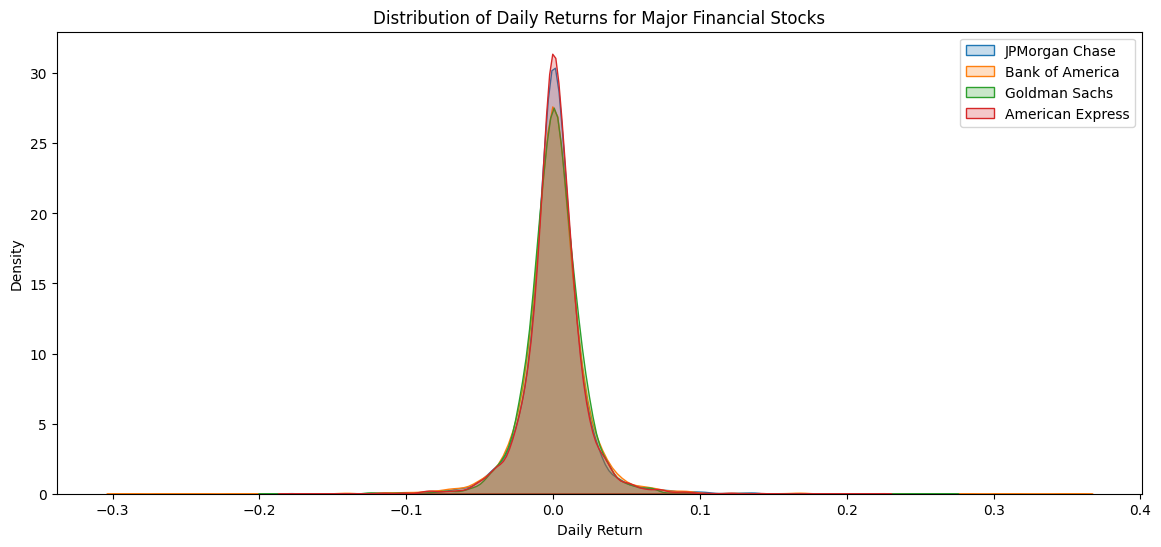

In [ ]:
plt.figure(figsize=(14,6))

for stock in ["JPMorgan Chase", "Bank of America", "Goldman Sachs", "American Express"]:
    sns.kdeplot(df_returns[f"{stock}_ret"].dropna(), label=stock, fill=True)

plt.title("Distribution of Daily Returns for Major Financial Stocks")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.legend()
plt.show()

- Pairplot of Daily Returns

In the following pairplot provides a comprehensive view of pairwise relationships among the daily returns of the four financial stocks. The diagonal plots reveal the individual return distributions, while the off-diagonal scatter plots show strong co-movement and linear relationships between many stock pairs. This suggests that the selected stocks are influenced by shared market drivers such as interest rates, economic conditions, and sector-specific news. These insights reinforce the value of including both macroeconomic features and cross-stock information in the predictive modeling pipeline.

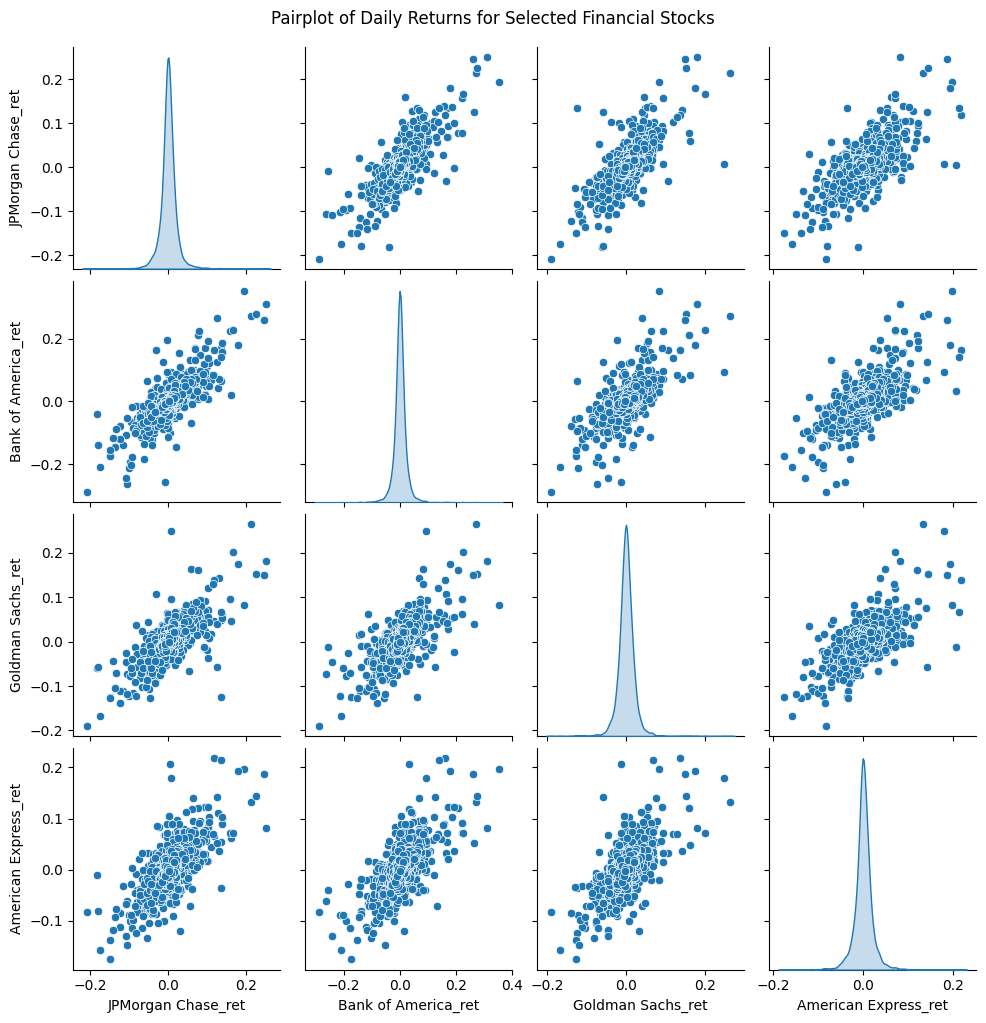

In [ ]:
sns.pairplot(
    df_returns[[f"{s}_ret" for s in target_stocks]].dropna(),
    diag_kind="kde"
)
plt.suptitle("Pairplot of Daily Returns for Selected Financial Stocks", y=1.02)
plt.show()

- Scatter Plot: 10Y Treasury Yield (t-1) vs S&P500 ETF (t-1)

This scatter plot below visualizes the relationship between the lagged 10-year Treasury yield and the lagged price of the S&P 500 ETF (SPY). The slight downward trend reflects a well-known financial principle: rising interest rates tend to depress equity valuations due to increased discount rates and borrowing costs. This inverse relationship confirms that macroeconomic conditions—especially interest-rate movements—play a significant role in shaping stock market performance. Including variables like the Treasury yield in the machine learning feature set is therefore essential for capturing broader economic forces that influence future market direction.

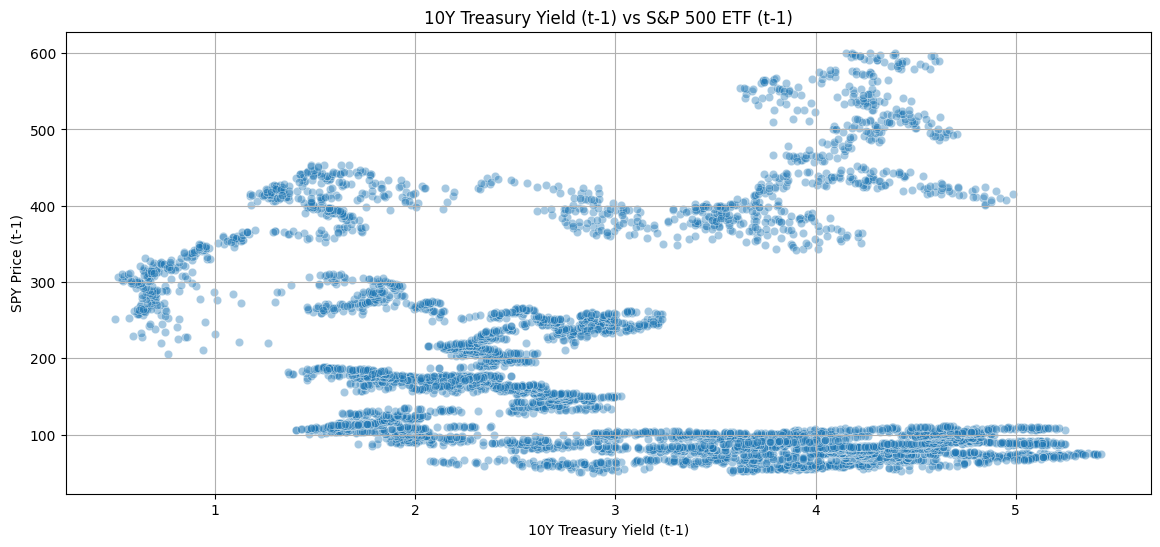

In [ ]:
plt.figure(figsize=(14,6))
sns.scatterplot(
    x=df["10Y Treasury Yield(t-1)"],
    y=df["S&P500 ETF(t-1)"],
    alpha=0.4
)

plt.title("10Y Treasury Yield (t-1) vs S&P 500 ETF (t-1)")
plt.xlabel("10Y Treasury Yield (t-1)")
plt.ylabel("SPY Price (t-1)")
plt.grid(True)
plt.show()

**7. Visualizations for ML features**

This part was done by - Rahul Gadhavi

**7.1. 20-Day Rolling Volatility**

This visualization presents the 20-day rolling volatility for four major financial stocks. Rolling volatility provides insight into the time-varying risk characteristics of each stock and highlights periods of heightened market stress. The plot clearly shows volatility clustering, where calm periods are followed by turbulence, such as during the 2008 financial crisis and the COVID-19 crash.

Understanding volatility dynamics is essential for financial prediction tasks because ML models tend to perform differently across market regimes. This analysis also supports incorporating volatility-based technical indicators in the modeling pipeline.

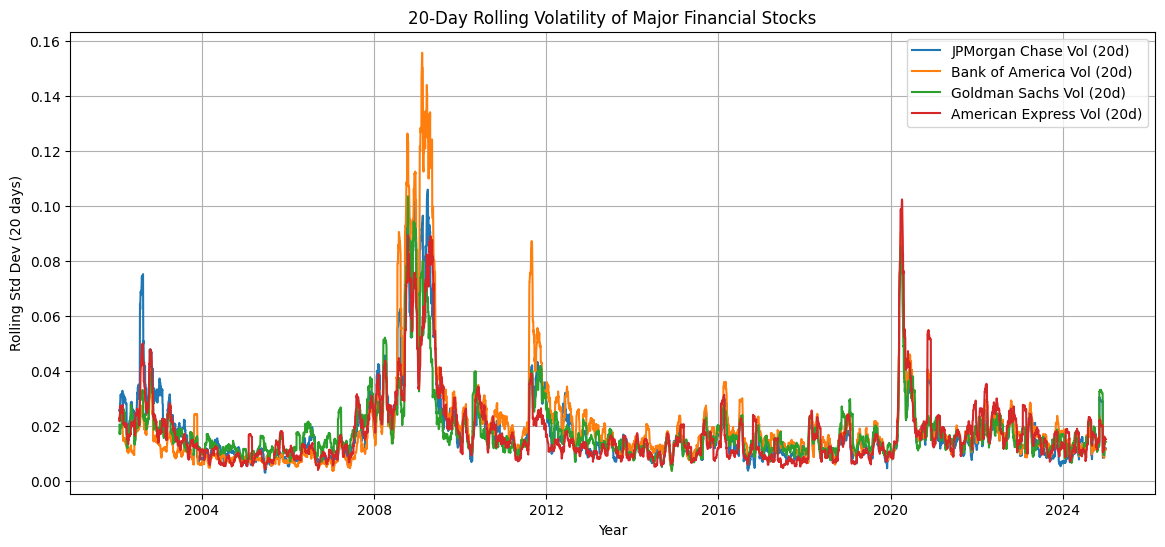

In [ ]:
plt.figure(figsize=(14,6))

for stock in ["JPMorgan Chase", "Bank of America", "Goldman Sachs", "American Express"]:
    df_returns[f"{stock}_vol20"] = df_returns[f"{stock}_ret"].rolling(20).std()
    plt.plot(df_returns[f"{stock}_vol20"], label=f"{stock} Vol (20d)")

plt.title("20-Day Rolling Volatility of Major Financial Stocks")
plt.xlabel("Year")
plt.ylabel("Rolling Std Dev (20 days)")
plt.legend()
plt.grid(True)
plt.show()

**7.2. Lag-1 Autocorrelation of Returns**

This bar chart summarizes the lag-1 autocorrelation of daily returns for the selected financial stocks. The autocorrelation values are slightly negative, indicating mild mean reversion in daily equity returns. This behavior is characteristic of liquid equity markets, where short-term movements resemble random noise.
The weak autocorrelation demonstrates that yesterday’s return carries limited predictive information about tomorrow’s movement. Consequently, this EDA explains why machine learning models may not strongly outperform simple baselines and supports the need for richer feature sets beyond raw returns, such as macroeconomic indicators or multi-period technical features.

/tmp/ipython-input-3796801849.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


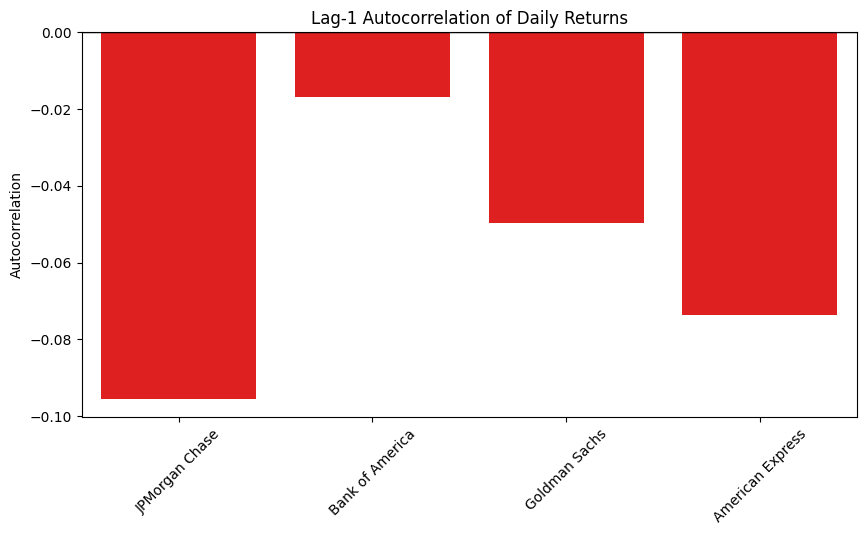

In [ ]:
autocorr_values = {}

plt.figure(figsize=(10,5))
for stock in target_stocks:
    autocorr = df_returns[f"{stock}_ret"].autocorr(lag=1)
    autocorr_values[stock] = autocorr

sns.barplot(
    x=list(autocorr_values.keys()),
    y=list(autocorr_values.values()),
    palette=["red" if v < 0 else "green" for v in autocorr_values.values()],
)

plt.axhline(0, color='black', linewidth=1)  # zero reference line
plt.title("Lag-1 Autocorrelation of Daily Returns")
plt.ylabel("Autocorrelation")
plt.xticks(rotation=45)
plt.show()

**7.3. VIX vs JPMorgan Return Scatter Plot**

This scatter plot visualizes the relationship between the lagged VIX level and next-day JPMorgan returns. The observed inverse pattern indicates that higher market uncertainty (higher VIX) often corresponds to lower or more volatile stock returns.

This result confirms that macroeconomic sentiment indicators such as VIX contain valuable predictive information that is not present in raw stock returns alone. This EDA motivates the inclusion of macro lag features in the machine learning models and suggests that non-linear relationships in the data may be better captured by tree-based models like Random Forest or XGBoost.

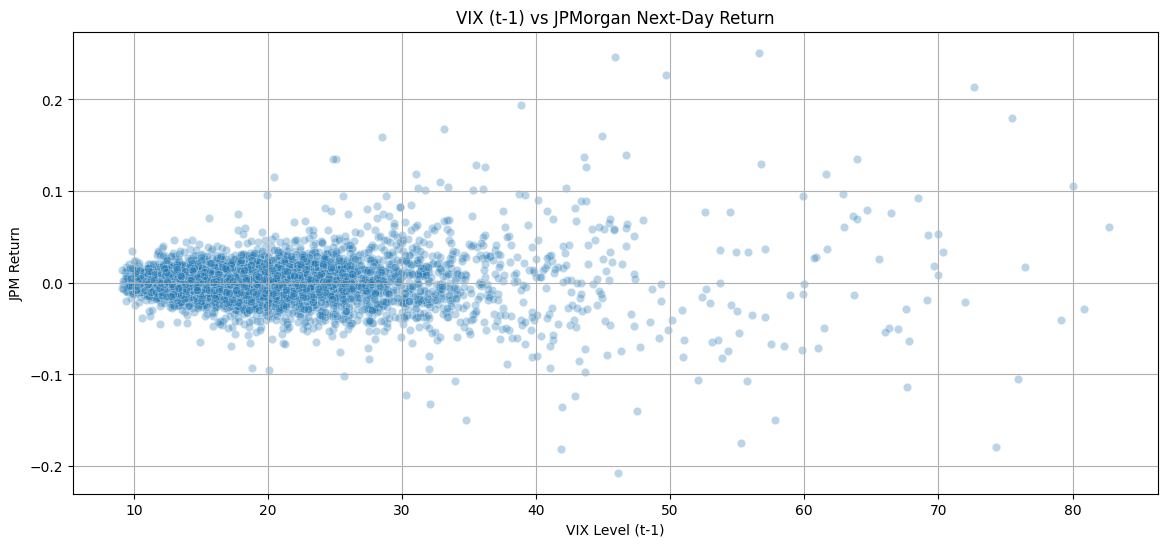

In [ ]:
plt.figure(figsize=(14,6))
sns.scatterplot(
    x=df_returns["VIX Volatility Index(t-1)"],
    y=df_returns["JPMorgan Chase_ret"],
    alpha=0.3
)

plt.title("VIX (t-1) vs JPMorgan Next-Day Return")
plt.xlabel("VIX Level (t-1)")
plt.ylabel("JPM Return")
plt.grid(True)
plt.show()

**7.4. Cumulative Returns of the 4 Stocks**

This plot shows the cumulative return of the four main financial stocks, assuming a $1 investment in each at the start of the sample period. It allows us to compare long-run performance across the financial sector and see which institutions delivered higher growth over time. This visualization is useful because it connects the daily return modeling task to an intuitive economic outcome (wealth growth), and it helps motivate why accurate direction or return prediction could matter for portfolio construction.

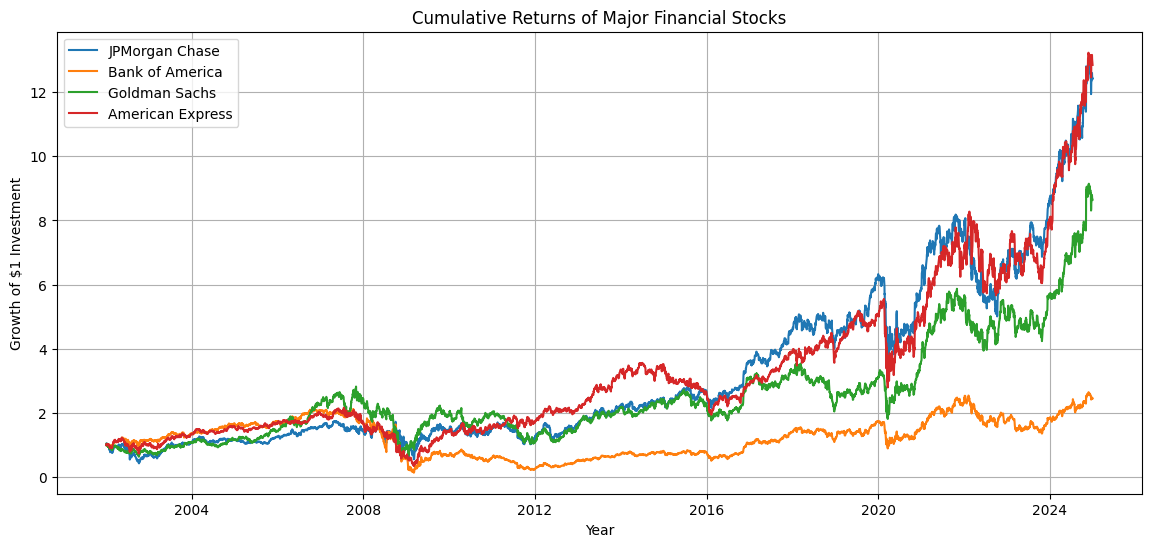

In [ ]:
# Cumulative returns for the four main financial stocks

plt.figure(figsize=(14,6))

ret_cols = [f"{s}_ret" for s in target_stocks]

# Replace NaNs with 0 for returns (e.g., first day)
cum_ret = (1 + df_returns[ret_cols].fillna(0)).cumprod()

for stock in target_stocks:
    plt.plot(cum_ret[f"{stock}_ret"], label=stock)

plt.title("Cumulative Returns of Major Financial Stocks")
plt.xlabel("Year")
plt.ylabel("Growth of $1 Investment")
plt.grid(True)
plt.legend()
plt.show()

**7.5. Max Drawdown analysis of major financial stocks**

This plot shows the drawdowns of the four major financial stocks, measuring how far each stock falls from its previous peak at any point in time. Drawdowns are a standard way to quantify market stress and investor losses. The differences between the depth and frequency of drawdowns across stocks demonstrate that institutions react differently to stressful market conditions. Some stocks experience severe peak-to-trough declines, while others show milder or less frequent drops. This supports the hypothesis that stock-specific behavior needs to be considered in machine learning models, as each financial institution exhibits distinct sensitivity to adverse market environments.


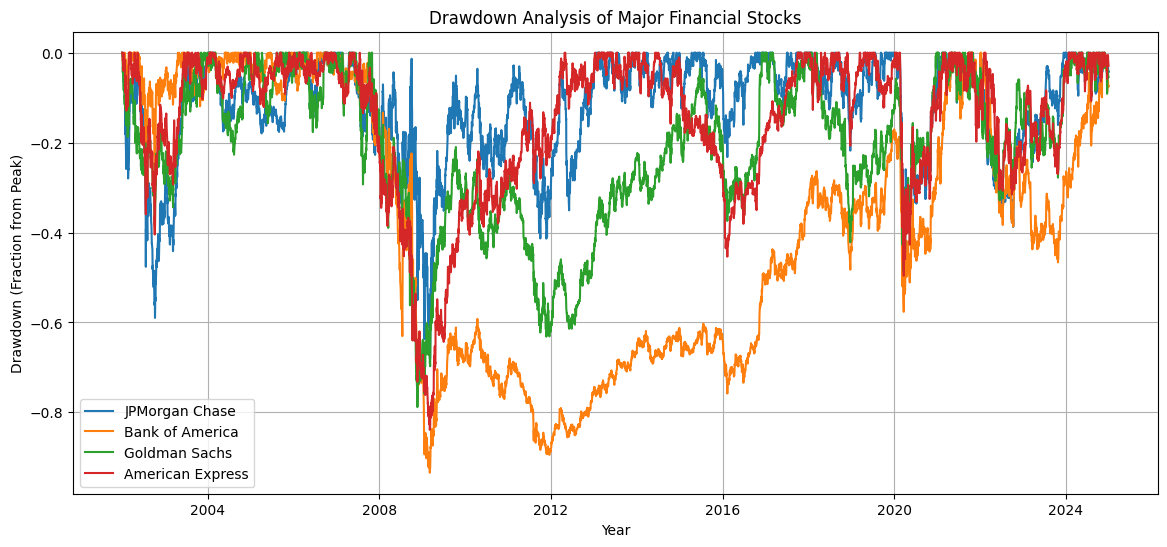

In [ ]:
plt.figure(figsize=(14,6))

drawdowns = {}

for stock in target_stocks:
    # Cumulative returns
    cum_ret = (1 + df_returns[f"{stock}_ret"].fillna(0)).cumprod()

    # Running maximum
    running_max = cum_ret.cummax()

    # Drawdown series
    drawdown = (cum_ret - running_max) / running_max
    drawdowns[stock] = drawdown

    plt.plot(drawdown, label=stock)

plt.title("Drawdown Analysis of Major Financial Stocks")
plt.xlabel("Year")
plt.ylabel("Drawdown (Fraction from Peak)")
plt.grid(True)
plt.legend()
plt.show()

**Transistioning from EDA and Visualisation to further ML models**

The exploratory data analysis above highlights several important characteristics of financial time-series that directly influence model performance in the next section. The volatility plots, autocorrelation analysis, and macro–return relationships reveal that stock returns exhibit low predictability, regime-dependent behavior, and sensitivity to macroeconomic conditions. These findings help motivate why we evaluate multiple modeling approaches including the majority-class baseline, Logistic Regression, Random Forest, and XGBoost in the following section. Each model differs in its ability to capture linear trends, non-linear patterns, and interactions among returns and macro indicators. By understanding the statistical properties revealed in the EDA, we can better interpret the strengths, weaknesses, and results of the ML models presented below.

**5.2. Baseline model: Majority class**

For each stock, we start with a very simple baseline classifier.
We look only at the training labels and compute the majority class (whether the stock is mostly up days or mostly down days in the training period). The baseline model then predicts this same majority class for every day in the test period, ignoring all features.

It is important because financial returns are often imbalanced (for example, slightly more up days than down days over long periods). A model that always predicts the majority class can already achieve non-trivial accuracy. By computing accuracy, precision, recall and F1 for this baseline, we get a minimum reference level that our machine learning models should ideally beat.

In [ ]:
# Baseline: predict the majority class in the training set (up/down)
baseline_metrics = {}
baseline_accuracies = {}

for stock in target_stocks:
    label_col = f"{stock}_target"

    y = df_ml[label_col].values
    y_train = y[:train_size]
    y_test  = y[train_size:]

    # Majority class in train
    values, counts = np.unique(y_train, return_counts=True)
    majority_class = values[np.argmax(counts)]

    # Predict the same majority class for all test days
    y_pred = np.full_like(y_test, fill_value=majority_class)

    # Evaluation metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)

    baseline_metrics[stock] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "majority_class": int(majority_class),
        "train_class_distribution": dict(zip(values, counts)),
    }
    baseline_accuracies[stock] = round(acc * 100, 2)

rows = []
for stock, m in baseline_metrics.items():
    dist = m["train_class_distribution"]
    n_down = dist.get(0, 0)
    n_up   = dist.get(1, 0)
    total  = n_down + n_up
    pct_up = 100 * n_up / total if total else 0
    pct_down = 100 * n_down / total if total else 0

    rows.append({
        "Stock": stock,
        "Accuracy (%)": round(m["accuracy"] * 100, 2),
        "Precision (%)": round(m["precision"] * 100, 2),
        "Recall (%)": round(m["recall"] * 100, 2),
        "F1 (%)": round(m["f1"] * 100, 2),
        "Majority Class (train)": m["majority_class"],
        "Train % Up (1)": round(pct_up, 2),
        "Train % Down (0)": round(pct_down, 2),
    })

baseline_df = pd.DataFrame(rows)
baseline_df

,Stock,Accuracy (%),Precision (%),Recall (%),F1 (%),Majority Class (train),Train % Up (1),Train % Down (0)
0,JPMorgan Chase,52.75,52.75,100.0,69.07,1,50.30,49.70
1,Bank of America,50.52,50.52,100.0,67.12,1,50.15,49.85
2,Goldman Sachs,51.89,51.89,100.0,68.33,1,50.86,49.14
3,American Express,52.67,52.67,100.0,69.00,1,50.47,49.53


**5.3. Logistic Regression**

The first actual ML model we try is Logistic Regression. This is a linear classifier that models the probability of the “up” class as a logistic function of the features.

We standardize all features using StandardScaler and then fit a logistic regression model for each stock separately, using the same training/test split as in the baseline. Logistic Regression is:

*   simple and relatively interpretable,
*   fast to train even on long time series, and
*   a good way to see whether a linear relationship between returns/macros and future direction is enough.

For each stock, we compare its test accuracy against the baseline accuracy to see whether adding these features actually improves predictive performance.


In [ ]:
logreg_accuracies = {}

# Pipeline: standardize features + logistic regression
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42))
])

for stock in target_stocks:
    label_col = f"{stock}_target"
    y = df_ml[label_col].values

    y_train = y[:train_size]
    y_test  = y[train_size:]

    logreg_pipeline.fit(X_train, y_train)
    y_pred = logreg_pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    logreg_accuracies[stock] = round(acc * 100, 2)

logreg_df = pd.DataFrame({
    "Stock": target_stocks,
    "LR Accuracy (%)": [logreg_accuracies[s] for s in target_stocks]
})
logreg_df

,Stock,LR Accuracy (%)
0,JPMorgan Chase,47.42
1,Bank of America,49.91
2,Goldman Sachs,49.83
3,American Express,49.91


**5.4. Random Forest**

Next, we use a Random Forest classifier, which is an ensemble of decision trees. Random Forests can model non-linear relationships and interactions between features that Logistic Regression might miss.

Key reasons for using Random Forest:


*   It handles mixed features and correlations fairly well.
*   It is robust to noise and tends to overfit less than a single decision tree due to averaging over many trees.
*   It can, in later stages, provide feature importance scores (which we can use to see which macro variables or returns are most useful).

We again train a separate Random Forest for each stock using the same features and the same time-based split. The goal is to check whether allowing non-linear patterns yields a noticeable improvement in accuracy over both the baseline and logistic regression.


In [ ]:
rf_accuracies = {}

for stock in target_stocks:
    label_col = f"{stock}_target"
    y = df_ml[label_col].values

    y_train = y[:train_size]
    y_test  = y[train_size:]

    rf_clf = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )

    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    rf_accuracies[stock] = round(acc * 100, 2)

rf_df = pd.DataFrame({
    "Stock": target_stocks,
    "RF Accuracy (%)": [rf_accuracies[s] for s in target_stocks]
})
rf_df

,Stock,RF Accuracy (%)
0,JPMorgan Chase,48.62
1,Bank of America,51.64
2,Goldman Sachs,50.09
3,American Express,47.59


**5.5. XGBoost**

Finally, we experiment with XGBoost (XGBClassifier), a gradient-boosted tree method. XGBoost builds trees sequentially, where each new tree tries to correct the errors of the previous ones. It usually performs very well on structured tabular data.

We chose XGBoost because:


*   it often captures subtle patterns and interactions in financial data,
*   it includes regularization and several hyperparameters that help control overfitting, and
*   it is widely used in practice for prediction problems similar to ours.

We train a separate XGBoost model for each of the four target stocks using the same feature set and train/test split. We then compare the XGBoost test accuracy to the baseline, logistic regression, and Random Forest results in a combined summary table.

In [ ]:
xgb_accuracies = {}

for stock in target_stocks:
    label_col = f"{stock}_target"
    y = df_ml[label_col].values

    y_train = y[:train_size]
    y_test  = y[train_size:]

    xgb = XGBClassifier(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss"
    )

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    xgb_accuracies[stock] = round(acc * 100, 2)

xgb_df = pd.DataFrame({
    "Stock": target_stocks,
    "XGBoost Accuracy (%)": [xgb_accuracies[s] for s in target_stocks]
})
xgb_df

,Stock,XGBoost Accuracy (%)
0,JPMorgan Chase,47.68
1,Bank of America,50.43
2,Goldman Sachs,50.77
3,American Express,48.97


In [ ]:
combined_rows = []

for stock in target_stocks:
    combined_rows.append({
        "Stock": stock,
        "Baseline Acc (%)": baseline_accuracies[stock],
        "LR Acc (%)": logreg_accuracies[stock],
        "RF Acc (%)": rf_accuracies[stock],
        "XGBoost Acc (%)": xgb_accuracies[stock],
    })

combined_acc_df = pd.DataFrame(combined_rows)
combined_acc_df

,Stock,Baseline Acc (%),LR Acc (%),RF Acc (%),XGBoost Acc (%)
0,JPMorgan Chase,52.75,47.42,48.62,47.68
1,Bank of America,50.52,49.91,51.64,50.43
2,Goldman Sachs,51.89,49.83,50.09,50.77
3,American Express,52.67,49.91,47.59,48.97


The majority-class baseline performs surprisingly well because daily stock returns are naturally imbalanced. There are slightly more “up” days than “down” days over long periods. Since the baseline always predicts the dominant class, it achieves relatively high accuracy without learning anything. In contrast, the ML models are trying to learn patterns from features that contain very weak predictive signal at the daily level, so they can easily overfit noise and generalize worse than the baseline. This behavior is common in financial prediction, where short-term movements are highly random. The results highlight the difficulty of the task and show that more complex time-series methods or richer features may be needed to improve performance.

**8. Reflection**

**8.1. Most challenging part so far** has been designing the modeling pipeline in a way that respects the time-series nature of the data. It is easy to accidentally leak future information (for example, by shuffling data or using statistics computed over the whole series), so we had to be careful with how we created features and split train vs. test. Another challenge has been deciding which features are useful without making the model unnecessarily complex.

**8.2. Initial insights**

From the exploratory analysis and the correlation heatmap, we see that:

*   the large financial stocks move strongly together and are also tied to the overall market (SPY),
*   macro variables such as VIX and the 10Y yield have noticeable relationships with the stock series (for example, VIX often moves opposite to stock prices).

In the modeling results, the machine learning models sometimes improve over the majority-class baseline, but the gains are not huge, which is consistent with how hard it is to predict daily stock direction.

**8.3. Concrete results so far**

We already have:

*   a clean, reproducible data pipeline,
*   defined labels for the directional classification task, and
*   test accuracies for the baseline, Logistic Regression, Random Forest and XGBoost for four major financial stocks.

The accuracies vary by stock and model, but in several cases the Random Forest and XGBoost models slightly outperform the baseline. These results are preliminary; we have not yet tuned hyperparameters aggressively or evaluated risk-adjusted portfolio metrics.


**8.4. Current biggest problems**

The main issues we are facing right now are:

*   **Limited predictive power** at the daily frequency: even with several features, the models only achieve modest improvements over the baseline.
*   **Feature design**: we have not yet incorporated more sophisticated technical indicators (moving averages, volatility windows, etc.) that were mentioned in the proposal.
*   **Evaluation**: so far we focus mostly on accuracy; for the portfolio angle we will need to translate predictions into positions and measure returns, Sharpe ratio, drawdowns, etc.

**8.5. Are we on track?**

Overall we are on track with the data and classical ML parts:

*   Data collection and cleaning are essentially done.
*   Baseline and initial ML models are implemented and evaluated.

We still need to focus on:

*   LSTM modeling for next-day returns, and
*   the portfolio construction/backtesting part.

Those will need more dedicated time in the next phase.

**8.6. Is it worth proceeding with this project?**

Yes, the project still looks worthwhile:


*   The correlations and early model results suggest there is some signal in combining stock returns with macro indicators, even if it is weak.

*   The current pipeline gives us a solid foundation to plug in more advanced models (like LSTM) and more complex features.


If we find that daily prediction is too noisy, one adjustment we might consider is shifting to longer horizons (e.g., weekly returns) or focusing on a subset of regimes (e.g., high-volatility periods). Another option is to put more emphasis on the portfolio evaluation side—sometimes even small predictive edges can matter when combined with risk management.

**9. Next step**

Our goals are:

1.   Extend feature engineering

*   Add technical indicators such as moving averages (5-day, 20-day), rolling volatility, and possibly volume-based features.

*   Experiment with additional macro or sector-specific variables if time permits.


2.   Implement LSTM models


*   Reformulate the task as a sequence prediction problem where we feed a window of past returns and macro variables into an LSTM and predict either: the next-day return, or the next-day direction.

*   Compare LSTM performance against the tree-based models and logistic regression.



3.   Portfolio construction


*   Use the predicted signals (from either the best classical model or the LSTM) to build a simple long-only or long/flat portfolio.




